In [38]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras import regularizers
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [39]:
samples = []
#csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv']
csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv', \
            'data/data/data_pat/track1_central/driving_log.csv', 'data/data/data_pat/track1_recovery/driving_log.csv', \
            'data/data/data_pat/track1_recovery_reverse/driving_log.csv', 'data/data/data_pat/track1_reverse/driving_log.csv']
for j in range(7):
    if j==8:
        # 0 = my own data, 1 = Udacity supplied data , any other no = use both dataset
        print('not using dataset ', j)
        continue
    with open(csv_path[j]) as csvfile:
        #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
        reader = csv.reader(csvfile)
        for line in reader:
             # skip it if ~0 speed - not representative of driving behavior
            if float(line[6]) < 0.1 :
                continue
            if (float(line[3])>0.01 and float(line[3])<0.99) or (float(line[3])>-0.99 and float(line[3])<-0.01):
                samples.append(line)
            else:
                select_prob = np.random.random()
                if select_prob > 0.85:
                    samples.append(line)
                
            #samples.append(line)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2, random_state=42)
print (len(samples), len(train_samples), len(validation_samples), samples[550])
a= np.array(samples)

10094 8075 2019 ['IMG/center_2016_12_01_13_34_31_353.jpg', 'IMG/left_2016_12_01_13_34_31_353.jpg', 'IMG/right_2016_12_01_13_34_31_353.jpg', '0.1287396', '0.9855326', '0', '30.18339']


[-0.9903171  -0.91070442 -0.83109173 -0.75147905 -0.67186636 -0.59225368
 -0.512641   -0.43302831 -0.35341563 -0.27380294 -0.19419026 -0.11457758
 -0.03496489  0.04464779  0.12426048  0.20387316  0.28348584  0.36309853
  0.44271121  0.5223239   0.60193658  0.68154926  0.76116195  0.84077463
  0.92038732  1.        ] [  66    4   13   20   20   28   95  111  271  523  773 1578 3229 1493 1018
  334  268   95   52   22   15    6    2    1   57    1]


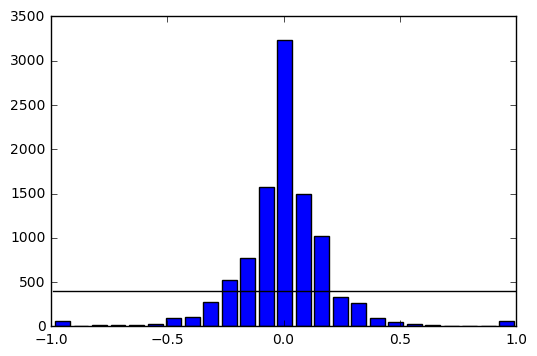

In [40]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [41]:
def read_image(row):
    
    steering_center = float(row[3])
    # create adjusted steering measurements for the side camera images
    offset=1.0 
    dist=10.0
    correction = offset/dist * 360/( 2*np.pi) / 25.0     #17# this is a parameter to tune
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    camera = np.random.choice(['center', 'left', 'right'], p=[0.3,0.35,0.35])
    
    if camera == "center" :    
        img = np.asarray(Image.open(path+row[0]))
        steering = steering_center
    elif camera == "left" :    
        img = np.asarray(Image.open(path+row[1]))
        steering = steering_center + correction
    elif camera == "right" :    
        img = np.asarray(Image.open(path + row[2]))
        steering = steering_center - correction
    else:
         print ('Invalid camera or path :',camera, row )
    
    return img, steering

In [42]:
def transform_image(image,steering,ang_range,shear_range,trans_range):
# Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
# Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
# Shear
    rows,cols,ch = image.shape
    dx = np.random.randint(-shear_range,shear_range+1)
    #    print('dx',dx)
    random_point = [cols/2+dx,rows/2]
    pts1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])
    pts2 = np.float32([[0,rows],[cols,rows],random_point])
    M = cv2.getAffineTransform(pts1,pts2)
    dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 6.0    
    steering +=dsteering
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)
    
    #image2 = np.zeros(X_train[0].shape, dtype='u1')
    # Preprocessing 
    #image2 = brightness_process_image(image,image2)     # brightness Normalization & Augmentaion
    
    return image,steering

In [43]:
def crop_image(image, cam_angle=0.0, train = True):
    
    tx_lower=-20
    tx_upper=20
    ty_lower=-10
    ty_upper=10
    shape = image.shape
    steering = 0.0
    
    # note: numpy arrays are (row, col)!
    
    #tx and ty are random no of pixels # only for training data
    if train:
        tx= np.random.randint(tx_lower,tx_upper+1)
        ty= np.random.randint(ty_lower,ty_upper+1)
        # the steering variable needs to be updated to counteract the shift 
        if tx != 0:
            steering = tx/(tx_upper-tx_lower)/3.0   #tx can be +ve or -ve (between -20 and 20)
    else:
        tx,ty=0,0   #for  validation data, turn randomness off

    
    #image cropping top:1/4th of height, bottom: 25px, left:20px, right:20px
    image = image[math.floor(shape[0]/4)+ty:shape[0]-25+ty, 20+tx:shape[1]-20+tx]
    image = cv2.resize(image, (64, 64))
    cam_angle += steering
    
    return image,cam_angle

In [44]:
def flip_image(image,cam_angle):
    img_flipped = np.fliplr(image)
    cam_angle_flipped = -cam_angle
    
    return img_flipped,cam_angle_flipped

In [45]:
def random_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.8 + 0.4*(2*np.random.uniform()-1.0)    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [46]:
def Augmentation(row, car_images=[], steering_angles=[], augment=False):
    
    
    image, cam_angle = read_image(row)
    
    image, cam_angle = transform_image(image, cam_angle, 2, 10, 2)
    
    image, cam_angle = crop_image(image, cam_angle, augment)
    
    image = random_brightness(image)
    
    # add images and angles to data set
    car_images.append(image)
    steering_angles.append(cam_angle)
    
    coin=np.random.randint(0,2)
    if coin==0 or coin==1:    
        image_flipped, cam_angle_flipped = flip_image(image,cam_angle)
        # add images and angles to data set
        car_images.append(image_flipped)
        steering_angles.append(cam_angle_flipped)
    
    
    return car_images, steering_angles

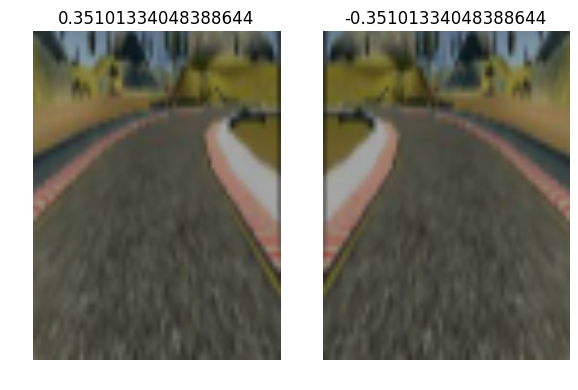

In [47]:
#Sample example

car_images_test = []
steering_angles_test = []

car_images_test, steering_angles_test = Augmentation(a[300], car_images_test, steering_angles_test, True)
for i in range(2):
    image = car_images_test[i]
    plt.subplot(1, 2, i+1)
    plt.tight_layout()
    #print(steering_angles[i])
    plt.imshow(image, aspect='auto')
    plt.title(steering_angles_test[i])
    plt.axis('off')

In [50]:
def generator(samples, augment=True, batch_size=256):
    num_samples = int(len(samples)/4)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []

            for row in batch_samples:
                if augment==True:
                    car_images, steering_angles = Augmentation(row, car_images, steering_angles)
                else:
                    car_images, steering_angles = Augmentation(row, car_images, steering_angles, False)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [51]:
# compile and train the model using the generator function
train_generator = generator(train_samples, augment=True, batch_size=256)
validation_generator = generator(validation_samples, augment=False, batch_size=256)

In [52]:
model = Sequential()
# Normalize
#model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
#model.add(Convolution2D(3,1,1,border_mode='valid', name='conv0'))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(16, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 13x13x16
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 5
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 3)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 32, 32, 16)    1216        lambda_5[0][0]                   
____________________________________________________________________________________________________
elu_21 (ELU)                     (None, 32, 32, 16)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 15, 15, 32)    4640        elu_21[0][0]                     
___________________________________________________________________________________________

Epoch 1/15
3584/4037 [=========================>....] - ETA: 0s - loss: 0.1244

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4096/4037 [==============================] - 10s - loss: 0.1241 - val_loss: 0.0679
Epoch 2/15
4096/4037 [==============================] - 7s - loss: 0.0900 - val_loss: 0.0512
Epoch 3/15
4096/4037 [==============================] - 6s - loss: 0.0721 - val_loss: 0.0458
Epoch 4/15
4096/4037 [==============================] - 6s - loss: 0.0638 - val_loss: 0.0474
Epoch 5/15
4096/4037 [==============================] - 6s - loss: 0.0585 - val_loss: 0.0425
Epoch 6/15
4096/4037 [==============================] - 6s - loss: 0.0581 - val_loss: 0.0477
Epoch 7/15
4096/4037 [==============================] - 6s - loss: 0.0543 - val_loss: 0.0511
Epoch 8/15
4096/4037 [==============================] - 6s - loss: 0.0521 - val_loss: 0.0480
Epoch 9/15
4096/4037 [==============================] - 6s - loss: 0.0518 - val_loss: 0.0462
Epoch 10/15
4096/4037 [==============================] - 6s - loss: 0.0529 - val_loss: 0.0510
Epoch 11/15
4096/4037 [==============================] - 6s - loss: 0.0505 - va

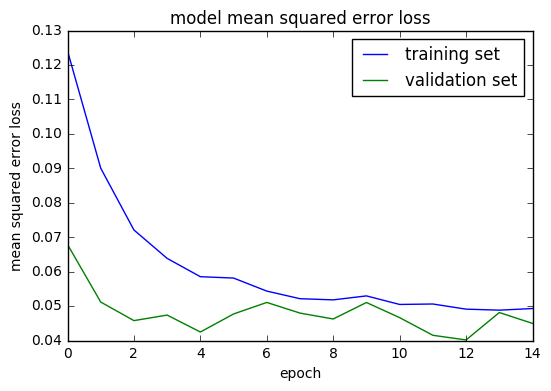

In [53]:
model.compile(loss='mse', optimizer=Adam(lr=1e-4))
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            math.floor(len(train_samples)*0.5), validation_data=validation_generator, \
            nb_val_samples=math.floor(len(validation_samples)*0.5), nb_epoch=15, verbose=1)          #https://keras.io/models/sequential/#fit_generator

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_test.h5')